In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.auto import tqdm
from tqdm.contrib import concurrent
from multiprocessing import Pool
import itertools
import glob
import os

# Functions

In [2]:
def fix_missing_dates(data_df):
    ## Deal with entire dates missing for certain tickers by dropping those tickers
    ## Input must include every single ticker's data
    
    # Number of unique dates with data for each ticker
    ticker_unique_dates = (
        data_df.groupby(["ticker"])["date"].apply(lambda x: len(x.unique())).sort_values()
    )

    # Get the maximum possible number of unique dates for a ticker
    max_unique_dates = ticker_unique_dates.value_counts().sort_values().index[-1]

    # Create list of ticks with that many unique dates
    ticker_unique_dates_subset = ticker_unique_dates.loc[
        ticker_unique_dates == max_unique_dates
    ].index

    # Filter data to this subset
    data_df = data_df.query("ticker in @ticker_unique_dates_subset").copy()

In [3]:
def fix_missing_datetimes(data_df):
    ## Add missing datetimes for each ticker

    # Create dataframe consisting of every {datetime, ticker} combination
    # Key assumption - all possible datetimes are represented in the
    # union of each tickers' data
    combinations_df = pd.DataFrame(
        [
            x
            for x in itertools.product(
                data_df["date"].unique(), data_df["datetime"].dt.time.unique(), data_df["ticker"].unique()
            )
        ],
        columns=["date", "time", "ticker"],
    )
    combinations_df["datetime"] = pd.to_datetime(
        combinations_df["date"].astype(str) + " " + combinations_df["time"].astype(str)
    )

    # Merge combinations_df with data so we can identify datetimes with missing prices
    merged_df = combinations_df.merge(data_df, on=["ticker", "date", "datetime"], how="left")

    # Forward fill in missing prices
    # Ensures every {ticker, date} combination will have 78 prices
    merged_df = merged_df.sort_values(by=["ticker", "datetime"]).reset_index(drop=True)
    merged_df["price_ffill"] = merged_df.groupby(["ticker", "date"])["price"].fillna(
        method="ffill"
    )
    merged_df["price_fill"] = merged_df.groupby(["ticker", "date"])[
        "price_ffill"
    ].fillna(method="bfill")

    return merged_df

In [4]:
def stock_split_adjust(data_df, ticker, split_date, split_ratio):
    ## Adjusts all prices before the split date by 
    ## dividing them by the split ratio 
    
    data_df = data_df.copy()
    data_df.loc[(data_df["ticker"] == ticker) & (data_df["datetime"] < split_date), "price"] = (
        data_df.loc[(data_df["ticker"] == ticker) & (data_df["datetime"] < split_date), "price"] / split_ratio
    )
    
    return data_df

In [12]:
def clean_ticker_prices_df(ticker_tuple):
    ## Reads in a data_df.groupby(ticker) object and cleans the data

    # Pull out info
    ticker = ticker_tuple[0]
    ticker_df = ticker_tuple[1]
    
    # Adjust dtypes
    ticker_df = ticker_df.astype(dtype={"ticker": "string"})

    # Add in missing dates
    ticker_df = (
        fix_missing_datetimes(ticker_df)
        .drop(["price_ffill", "price"], axis=1)
        .rename(columns={"price_fill": "price"})
    )

    # Stock splits
    ticker_df = stock_split_adjust(ticker_df, 'AAPL', '2020-08-31', 4)
    ticker_df = stock_split_adjust(ticker_df, 'AAPL', '2014-06-09', 7)
    ticker_df = stock_split_adjust(ticker_df, 'NFLX', '2015-07-15', 7)
    ticker_df = stock_split_adjust(ticker_df, 'GOOG', '2015-04-27', 1.0027455)
    
    return ticker, ticker_df

# Main

## Read in raw data

In [13]:
year_subset = list(range(2015,2021))
year_subset

[2015, 2016, 2017, 2018, 2019, 2020]

In [7]:
%%time
data_files = glob.glob("../data/prices/monthly_raw/*.feather")
data_files = [filename for filename in data_files if any(str(year) in filename for year in year_subset)]

monthly_dfs = []
for month_df in tqdm(map(pd.read_feather, data_files), total = len(data_files)):
    monthly_dfs.append(month_df)

rawdata_df = pd.concat(monthly_dfs)


CPU times: user 3.86 s, sys: 9.64 s, total: 13.5 s
Wall time: 10.4 s


In [8]:
data_df = rawdata_df.copy()

## Fix dates

In [9]:
%%time

# Number of unique dates with data for each ticker
ticker_unique_dates = (
    data_df.groupby(["ticker"])["date"].apply(lambda x: len(x.unique()))
)

# Get the maximum possible number of unique dates for a ticker
max_unique_dates = ticker_unique_dates.value_counts().sort_values().index[-1]

# Create list of ticks with that many unique dates
ticker_unique_dates_subset = ticker_unique_dates.loc[
    ticker_unique_dates == max_unique_dates
].index

# Filter data to this subset
data_df = data_df.query("ticker in @ticker_unique_dates_subset").reset_index(drop = True).copy()

CPU times: user 10.9 s, sys: 20.2 s, total: 31.1 s
Wall time: 32.3 s


## Clean Data and Export

In [10]:
%%time
ticker_list = list(data_df.groupby("ticker"))

CPU times: user 5.39 s, sys: 5.36 s, total: 10.8 s
Wall time: 10.8 s


In [ ]:
%%time

# Clean up old files
[os.remove(x) for x in glob.glob('../data/prices/tickers_clean/*.feather')]

# Save cleaned ones
with Pool(8) as p:

    for ticker, clean_ticker_df in tqdm(
        p.imap_unordered(clean_ticker_prices_df, data_df.groupby("ticker")),
        total=len(data_df["ticker"].unique()),
    ):

        clean_ticker_df.to_feather(
            f"../data/prices/tickers_clean/{ticker}_clean.feather"
        )

In [14]:
def temp_f(ticker_df_group):
    
    ticker, clean_ticker_df = clean_ticker_prices_df(ticker_df_group)
    
    clean_ticker_df.to_feather(
            f"../data/prices/tickers_clean/{ticker}_clean.feather"
        )

In [15]:
%%time

# Clean up old files
[os.remove(x) for x in glob.glob("../data/prices/tickers_clean/*.feather")]

# Save cleaned ones
with Pool(8) as p:

    for x in tqdm(
        p.imap_unordered(temp_f, data_df.groupby("ticker"), chunksize = 4),
        total=len(data_df["ticker"].unique()),
    ):
        continue


CPU times: user 11.2 s, sys: 17.5 s, total: 28.7 s
Wall time: 3min 39s


## Double check output

In [ ]:
%%time

def check_missing_datetimes(ticker_df):

    ticker_unique_datetimes = ticker_df.groupby(["date"])["datetime"].apply(
        lambda x: len(x.unique())
    )
    is_missing_datetime = ticker_unique_datetimes.min() < ticker_unique_datetimes.max()

    if is_missing_datetime:
        print("Missing datetimes:", ticker_df["ticker"].iloc[0])


data_files = glob.glob("../data/prices/tickers_clean/*.feather")[:90]
_ = concurrent.process_map(
    check_missing_datetimes, concurrent.process_map(pd.read_feather, data_files)
)

<AxesSubplot:>

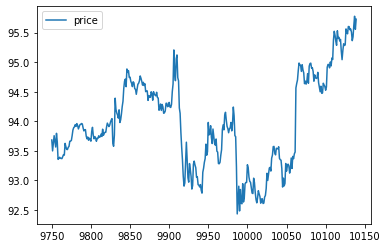

In [22]:
nflx_prices_df = pd.read_feather('../data/prices/tickers_clean/NFLX_clean.feather')
subset_df = nflx_prices_df.query('date > "2015-07-01" & date < "2015-07-10"').copy()
subset_df.plot(y = 'price')